In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import boto3

In [2]:
import boto3
import botocore

BUCKET_NAME = 'fog-datasets' # replace with your bucket name
TEST_KEY = 'rcf/data/test/data.csv' # replace with your object key
TRAIN_KEY = 'rcf/data/train/data.csv'
s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(TEST_KEY, 'test.csv')
    s3.Bucket(BUCKET_NAME).download_file(TRAIN_KEY, 'train.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [3]:
def read_data(file_path):
    df = pd.read_csv(file_path,index_col=0,parse_dates=True,header=None)
    df.index.name = 'Time'
    df.columns = ['Value']
    return df

x_train = read_data('train.csv')
x_test = read_data('test.csv')

In [4]:
np.abs([1,-1])

array([1, 1])

In [5]:
def rmsd(x1,x2):
    return np.sqrt(((x1 - x2)**2).mean())

In [6]:
class MeanPredictor():
    
    def __init__(self, freq='5min'):
        self.freq = freq
        
    def fit(self,x,square_deviation=False):
        x_group = x.groupby(np.array(list(map(self.__time_hash,x.index))).T.tolist())
        x_mean = x_group.mean()
        self.mean_dict = dict(zip(list(x_mean.index),x_mean.values.flatten()))
        if square_deviation:
            x_std_dist = x_group.std().values.squeeze()
        else:
            x_std_dist = np.array([np.abs(df.values - self.mean_dict[idx]).mean() for idx,df in list(x_group)])
        self.std_dict = dict(zip(list(x_mean.index),x_std_dist))
    
    def __time_hash(self,t):
        return (t.weekday() < 5,t.hour,t.minute)
    
    def __predict(self,t):
        t_hash = self.__time_hash(t)
        return self.mean_dict[t_hash], self.std_dict[t_hash]
    
    def __getitem__(self,t):
        if type(t) is slice:
            assert type(t.start) is pd.Timestamp
            assert type(t.stop) is pd.Timestamp
            assert t.step is None or type(t.step) is int
            step = t.step if type(t.step) is int else 1
            time_range = pd.date_range(t.start,t.stop,freq=self.freq)[::t.step]
            predictions = list(map(self.__predict,time_range))
            return pd.DataFrame(index=time_range,data=predictions,columns=['Value','Std'])
        else:
            assert t is pd.Timestamp
    


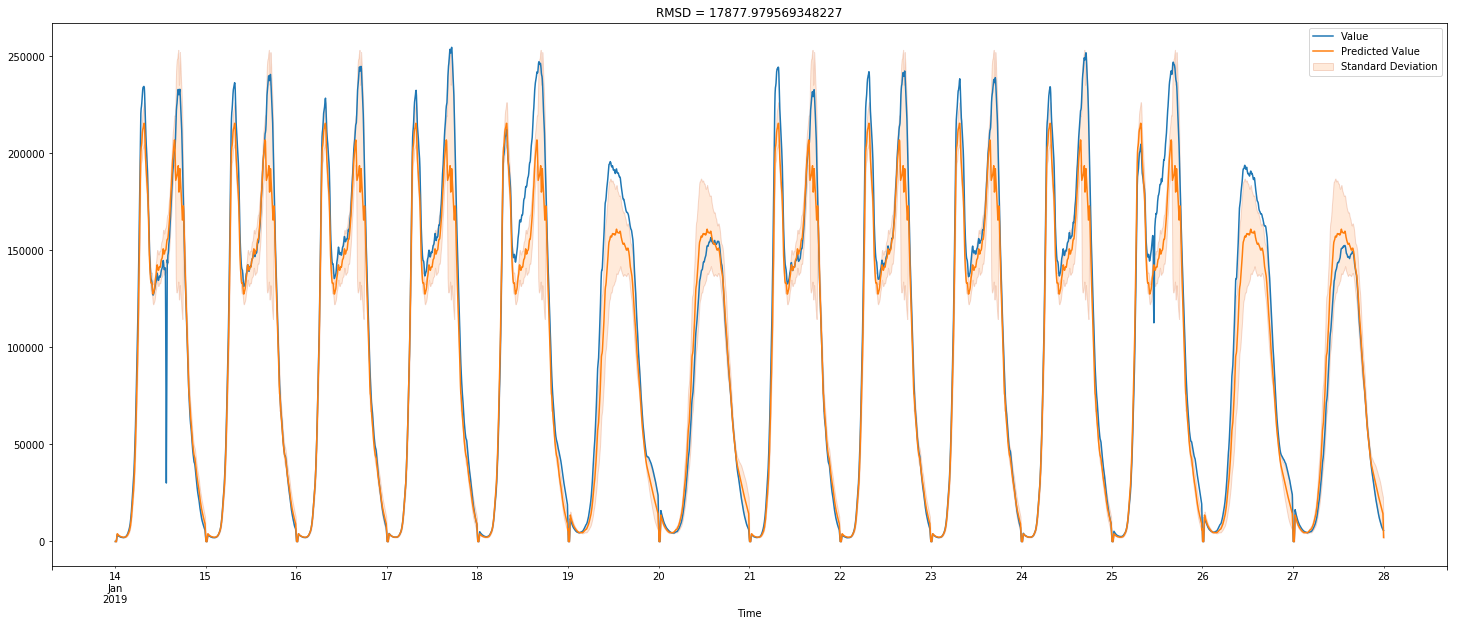

In [8]:
mean_predictor = MeanPredictor()
mean_predictor.fit(x_train[x_train.index > pd.Timestamp(2019,1,7)],False)
pred = mean_predictor[x_test.index[0]:x_test.index[-1]]
anomaly_idxs = np.abs(pred.Value.values - x_test.values.squeeze()) > np.abs(pred.Value.values-pred.Std.values)
ax = x_test.plot(figsize=(25,10),label='Test Data')
ax.fill_between(pred.index, pred.Value.values-pred.Std.values, pred.Value.values+pred.Std.values,
    alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF9848', label='Standard Deviation')
pred.Value.plot(ax=ax, label='Predicted Value')
ax.legend()
ax.set_title("RMSD = {}".format(rmsd(pred.Value.values,x_test.values.squeeze())));